In [ ]:
import pandas as pd
df = pd.read_csv("synthetic_xrd_comparison.csv")
ruff_ids = df["RRUFFID"].unique().tolist()
ruff_ids

['R080016',
 'R040130',
 'R050020',
 'R060593',
 'R050582',
 'R040054',
 'R050074',
 'R061085',
 'R061100',
 'R070174',
 'R040068',
 'R040129',
 'R050253',
 'R050402',
 'R060054',
 'R070268',
 'R050043',
 'R060418',
 'R080044',
 'R080092',
 'R040006',
 'R040067',
 'R050258',
 'R050449',
 'R050561',
 'R050626',
 'R060212',
 'R040119',
 'R050450',
 'R060080',
 'R060787',
 'R040004',
 'R050052',
 'R050408',
 'R040012',
 'R040061',
 'R061102',
 'R060688',
 'R040059',
 'R050104',
 'R060082',
 'R060193',
 'R060221',
 'R060275',
 'R070598',
 'R050654',
 'R040078',
 'R060195',
 'R040070',
 'R040170',
 'R050009',
 'R050048',
 'R050127',
 'R050128',
 'R050130',
 'R050307',
 'R150020',
 'R050437',
 'R050653',
 'R060680',
 'R050383',
 'R050313',
 'R050071',
 'R061082',
 'R061020',
 'R060083',
 'R060084',
 'R060093',
 'R060016',
 'R060078',
 'R040142',
 'R040036',
 'R050335',
 'R050342',
 'R050375',
 'R050409',
 'R060359',
 'R060550',
 'R060629',
 'R060737',
 'R050320',
 'R050332',
 'R070177',
 'R0

Top 3 best COD matches for RRUFFID R050582
    RRUFFID    CODID      RMSE
38  R050582  9015676  6.471360
42  R050582  1544681  6.702705
37  R050582  9004101  6.886669


/usr/local/lib/python3.10/dist-packages/pymatgen/io/cif.py:1312: UserWarning: Missing elements H from PMG structure composition
  if struct := self._get_structure(data, primitive, symmetrized, check_occu=check_occu):
/usr/local/lib/python3.10/dist-packages/pymatgen/core/structure.py:3087: UserWarning: Issues encountered while parsing CIF: Structure has implicit hydrogens defined, parsed structure unlikely to be suitable for use in calculations unless hydrogens added.
  struct = parser.parse_structures(primitive=primitive)[0]


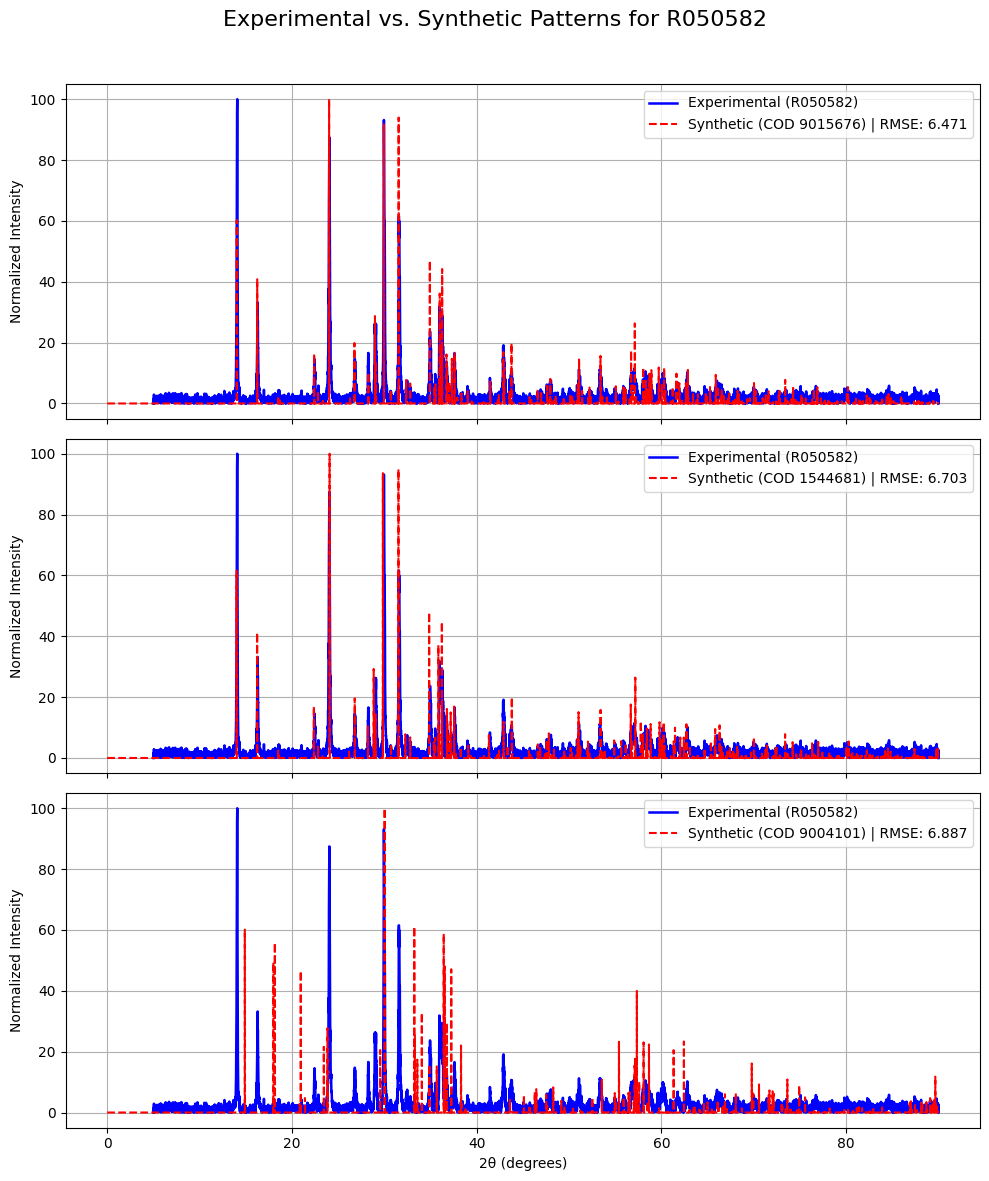

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import pymatgen for synthetic pattern generation
from pymatgen.core import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

def generate_synthetic_xrd(cif_path, wavelength=1.54184):
    """
    Generate a synthetic XRD pattern from a CIF using pymatgen's XRDCalculator.
    Returns (two_theta_list, intensity_list).
    """
    structure = Structure.from_file(cif_path)
    xrd_calc = XRDCalculator(wavelength=wavelength)
    pattern = xrd_calc.get_pattern(structure)
    return list(pattern.x), list(pattern.y)

def zero_pad_pattern(two_theta, intensities, num_points=8500, min_angle=5, max_angle=90.0):
    """
    Normalize and zero-pad an XRD pattern onto a fixed 2θ grid.
    Returns:
      (two_theta_grid, intens_grid) as numpy arrays.
    """
    two_theta = np.array(two_theta)
    intensities = np.array(intensities)
    
    if len(two_theta) == 0:
        return np.array([]), np.array([])
    
    # Normalize intensities so maximum equals 100
    max_intensity = intensities.max()
    if max_intensity > 0:
        intensities = (intensities / max_intensity) * 100
    
    # Create a uniform grid
    two_theta_grid = np.linspace(0, max_angle, num_points, dtype=np.float32)
    intens_grid = np.zeros(num_points, dtype=np.float32)
    
    indices = np.searchsorted(two_theta_grid, two_theta)
    indices = np.clip(indices, 0, num_points - 1)
    intens_grid[indices] = intensities
    
    return two_theta_grid, intens_grid

def parse_xy_file(filepath):
    """
    Parse a file containing XY data.
    Lines starting with "##" are ignored.
    Returns:
      two_theta (list of float), intensities (list of float)
    """
    two_theta = []
    intensities = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("##"):
                continue
            parts = line.split(',')
            if len(parts) < 2:
                continue
            try:
                two_theta.append(float(parts[0].strip()))
                intensities.append(float(parts[1].strip()))
            except Exception as e:
                print(f"Error parsing line in {filepath}: {line} -- {e}")
                continue
    return two_theta, intensities



def main(input_ruffid = "R050043"):
    # PARAMETERS (adjust as needed)
    input_RRUFFID = input_ruffid  # Specify the RRUFFID you want to analyze
    comparison_csv = "synthetic_xrd_comparison.csv"
    exp_folder = "XY_Processed_Parsed"  # Folder for experimental XRD files
    cif_folder = "cif_files"            # Folder for CIF files
    wavelength = 1.54184                # X-ray wavelength for synthetic XRD generation

    # Read the CSV file containing RRUFFID, CODID, and RMSE
    df = pd.read_csv(comparison_csv)

    # Filter for the specified RRUFFID and sort by RMSE (lowest first)
    df_filtered = df[df["RRUFFID"] == input_RRUFFID]
    if df_filtered.empty:
        print(f"No matches found in {comparison_csv} for RRUFFID '{input_RRUFFID}'.")
    else:
        df_best = df_filtered.sort_values("RMSE").head(3)
        print("Top 3 best COD matches for RRUFFID", input_RRUFFID)
        print(df_best)

        # Load experimental XRD pattern (assumed to already be on desired grid)
        exp_file = os.path.join(exp_folder, f"{input_RRUFFID}.txt")
        exp_two_theta, exp_intensities = parse_xy_file(exp_file)
        exp_two_theta = np.array(exp_two_theta)
        exp_intensities = np.array(exp_intensities)
        
        if exp_intensities.max() > 0:
            exp_intensities = (exp_intensities / exp_intensities.max()) * 100

        # Use the experimental grid parameters for synthetic data
        num_points = len(exp_two_theta)  # using the experimental grid
        max_angle_exp = exp_two_theta.max() if exp_two_theta.size > 0 else 90.0

        # Set up 3 subplots
        fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

        # Iterate over each of the three best matches
        for ax, (_, row) in zip(axs, df_best.iterrows()):
            cod_id = str(row["CODID"])
            rmse_val = row["RMSE"]
            cif_path = os.path.join(cif_folder, f"{cod_id}.cif")
            
            try:
                syn_two_theta, syn_intensities = generate_synthetic_xrd(cif_path, wavelength=wavelength)
            except Exception as e:
                print(f"Error generating synthetic pattern for CIF {cif_path}: {e}")
                continue
            
            # Zero-pad the synthetic pattern to match the experimental grid
            grid_syn, intens_syn = zero_pad_pattern(syn_two_theta, syn_intensities, num_points=num_points, max_angle=max_angle_exp)
            
            # Plot experimental pattern
            ax.plot(exp_two_theta, exp_intensities, label=f"Experimental ({input_RRUFFID})", color="blue", lw=1.8)
            # Plot synthetic pattern
            ax.plot(grid_syn, intens_syn, lw=1.5, linestyle="--", color="red", 
                    label=f"Synthetic (COD {cod_id}) | RMSE: {rmse_val:.3f}")
            ax.set_ylabel("Normalized Intensity")
            ax.grid(True)
            ax.legend()
        
        axs[-1].set_xlabel("2θ (degrees)")
        fig.suptitle(f"Experimental vs. Synthetic Patterns for {input_RRUFFID}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()



main(ruff_ids[4])

In [1]:
import pandas as pd

df = pd.read_csv("synthetic_xrd_comparison.csv")
filter_variable = "R050488"

df_filtered =df[df['RRUFFID'] == filter_variable]

df_filtered[["CODID", "RMSE"]].sort_values(by='RMSE')


,CODID,RMSE
13573,9002555,3.761568
13574,9002556,3.762729
13575,9002557,3.781985
13572,9002554,3.815328
13576,9002558,3.828364
13577,9002559,3.888496
13563,9000230,3.893870
13562,5000119,3.893870
13579,9002561,3.906184
13564,9000684,3.920830


0
1
2
3


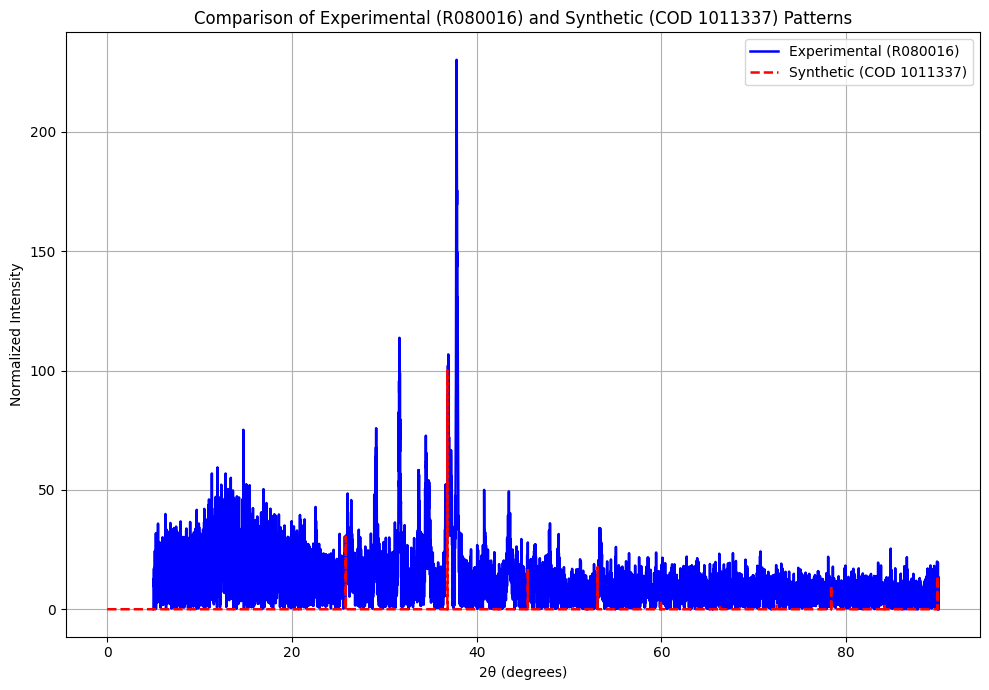

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Import pymatgen for synthetic pattern generation
from pymatgen.core import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

def generate_synthetic_xrd(cif_path, wavelength=1.54184):
    """
    Generate a synthetic XRD pattern from a CIF using pymatgen's XRDCalculator.
    Returns (two_theta_list, intensity_list).
    """
    structure = Structure.from_file(cif_path)
    xrd_calc = XRDCalculator(wavelength=wavelength)
    pattern = xrd_calc.get_pattern(structure)
    return list(pattern.x), list(pattern.y)

def zero_pad_pattern(two_theta, intensities, num_points=8500, min_angle=5, max_angle=90.0):
    """
    Normalizes and zero-pads an XRD pattern onto a fixed 2θ grid.
    Returns:
      (two_theta_grid, intens_grid) as numpy arrays.
    """
    two_theta = np.array(two_theta)
    intensities = np.array(intensities)
    
    if len(two_theta) == 0:
        return np.array([]), np.array([])
    
    # Normalize intensities so that the maximum is 1.0
    max_intensity = intensities.max()
    if max_intensity > 0:
        intensities = intensities / max_intensity
    
    # Create a uniform grid
    two_theta_grid = np.linspace(0, max_angle, num_points, dtype=np.float32)
    intens_grid = np.zeros(num_points, dtype=np.float32)
    
    indices = np.searchsorted(two_theta_grid, two_theta)
    indices = np.clip(indices, 0, num_points-1)
    intens_grid[indices] = intensities
    
    return two_theta_grid, intens_grid

def parse_xy_file(filepath):
    """
    Parse a file containing XY data.
    Lines starting with "##" are ignored.
    Returns:
      two_theta (list of float), intensities (list of float)
    """
    two_theta = []
    intensities = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("##"):
                continue
            parts = line.split(',')
            if len(parts) < 2:
                continue
            try:
                two_theta.append(float(parts[0].strip()))
                intensities.append(float(parts[1].strip()))
            except Exception as e:
                print(f"Error parsing line in {filepath}: {line} -- {e}")
                continue
    return two_theta, intensities

# Set the folders where the experimental and synthetic files are stored
exp_folder = "XY_Processed_Parsed"  # Experimental XRD files folder (named as <RRUFFID>.txt)
cif_folder = "cif_files"            # CIF files folder (named as <CODID>.cif)
wavelength = 1.54184                # X-ray wavelength for synthetic XRD generation

def plot_experimental_synthetic(rruffid, codid):
    """
    Reads the experimental pattern from the RRUFFID file and generates the synthetic pattern from the CODID CIF.
    Zero pads the synthetic pattern and plots both patterns on the same plot.
    """
    # Construct the experimental file path
    print(0)
    exp_file = os.path.join(exp_folder, f"{rruffid}.txt")
    if not os.path.isfile(exp_file):
        print(f"Experimental file {exp_file} not found.")
        return
    exp_two_theta, exp_intensities = parse_xy_file(exp_file)
    exp_two_theta = np.array(exp_two_theta)
    exp_intensities = np.array(exp_intensities)
    print(1)
    # Construct the CIF file path and generate synthetic pattern
    cif_path = os.path.join(cif_folder, f"{codid}.cif")
    if not os.path.isfile(cif_path):
        print(f"Synthetic CIF file {cif_path} not found.")
        return
    try:
        syn_two_theta, syn_intensities = generate_synthetic_xrd(cif_path, wavelength=wavelength)
    except Exception as e:
        print(f"Error generating synthetic pattern from {cif_path}: {e}")
        return
    print(2)
    # Zero-pad synthetic pattern to match the experimental grid
    num_points = len(exp_two_theta)
    max_angle_exp = exp_two_theta.max() if exp_two_theta.size > 0 else 90.0
    grid_syn, intens_syn = zero_pad_pattern(syn_two_theta, syn_intensities, num_points=num_points, max_angle=max_angle_exp)
    print(3)
    # Plotting both patterns
    plt.figure(figsize=(10, 7))
    plt.plot(exp_two_theta, exp_intensities, label=f"Experimental ({rruffid})", color="blue", lw=1.8)
    plt.plot(grid_syn, intens_syn*100, label=f"Synthetic (COD {codid})", color="red", linestyle="--", lw=1.8)
    plt.xlabel("2θ (degrees)")
    plt.ylabel("Normalized Intensity")
    plt.title(f"Comparison of Experimental ({rruffid}) and Synthetic (COD {codid}) Patterns")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Change these variables as desired
rruffid = "R080016"  # Replace with your desired RRUFFID (experimental file name without extension)
codid   = "1011337"  # Replace with your desired CODID (synthetic CIF file name without extension)

# Plot the comparison
plot_experimental_synthetic(rruffid, codid)
